In [1]:
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Lectura en modo binario 
name = "E:\\Servicio\\MEA2\\20211005\\H5\\SPK\\CTR20211005s02_SPK.pckl"
electrodes_pkl = open(name,'rb') 

# Cargamos los datos del fichero
electrodes = pickle.load(electrodes_pkl)
electrodes_pkl.close()

71730


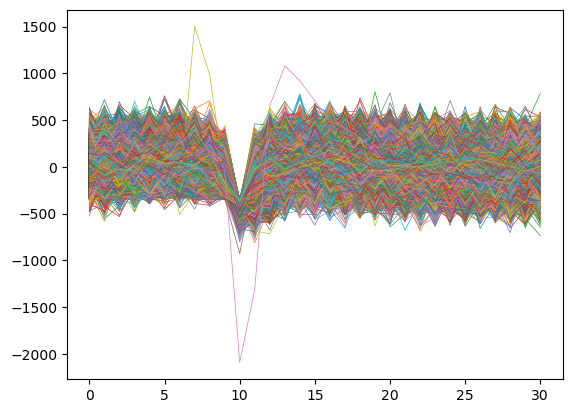

In [4]:
plt.plot(electrodes['SegmentData_35'].T,linewidth=0.5)
print(len(electrodes['SegmentData_35']))

In [5]:
# Uso de UMAP
import umap
import umap.plot

In [6]:
def spike_reducer(
    spikes,
    n_neighbors=70,
    n_components=2,
    metric="manhattan",
    n_epochs=800,
    min_dist=0,
    random_state=None,
    low_memory=False,
    outlier_disconnection=0,
    set_op_mix_ratio=0.5,
    **kwargs
):
    """Projects collection of spikes in the timeseries space to a lower
    dimensional UMAP embedding.

    Parameters
    ----------
    spikes : array, shape (n_spikes,n_sample_points)
        Array of all spikes you to embedd in a reduced dimensional space.

     n_neighbors: float (optional, default 100)
        The size of local neighborhood (in terms of number of neighboring
        sample points) used for manifold approximation. Larger values
        result in more global views of the manifold, while smaller
        values result in more local data being preserved. In general
        values should be in the range 2 to 100.

    n_components: int (optional, default 2)
        The dimension of the space to embed into. By default this is 2, other
        embedding dimensions may not work well with the rest of TopoSort

    metric: string or function (optional, default 'manhattan')
        The metric to use to compute distances in high dimensional space.
        If a string is passed it must match a valid predefined metric. If
        a general metric is required a function that takes two 1d arrays and
        returns a float can be provided. For performance purposes it is
        required that this be a numba jit'd function.

    n_epochs: int (optional, default 800)
        The number of training epochs to be used in optimizing the
        low dimensional embedding. Larger values result in more accurate
        embeddings.

    min_dist: float (optional, default 0)
        The effective minimum distance between embedded points. Smaller values
        will result in a more clustered/clumped embedding where nearby points
        on the manifold are drawn closer together, while larger values will
        result on a more even dispersal of points. The default value is 0 as
        this results in better performance when clustering. It's best not to
        change this to anything above 0.1

    random_state: int, RandomState instance or None, optional (default: None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    low_memory: bool (optional, default False)
        For some datasets the nearest neighbor computation can consume a lot of
        memory. If you have issues with memory consumption, consider changing
        this to True

    outlier_disconnection : float, (optional, default 0)
        When 0 we do not disconnect any vertices in our knn graph. When >0 it
        is the number of styandard deviations that we use as a cutoff for
        disconnecting vertices. If not 0, we reccomend a value of at least 6,
        anything less will disconnect too many vertices and mess with the
        embedding.

    set_op_mix_ratio: float (optional, default 1.0)
        Interpolate between (fuzzy) union and intersection as the set operation
        used to combine local fuzzy simplicial sets to obtain a global fuzzy
        simplicial sets. Both fuzzy set operations use the product t-norm.
        The value of this parameter should be between 0.0 and 1.0; a value of
        1.0 will use a pure fuzzy union, while 0.0 will use a pure fuzzy
        intersection.

    **kwargs :
        Additional UMAP parameters.

    Returns
    -------
    reducer: umap object that has already been fitted to the data. The spikes
             in the embedding space can be extracted with .embedding_ 
             attribute. Similarly, outliers can be extracted with the
             umap.utils.disconnected_vertices() function.
    """
    if outlier_disconnection > 0:
        knn = nearest_neighbors(
            spikes,
            n_neighbors,
            metric="manhattan",
            low_memory=False,
            metric_kwds=None,
            angular=False,
            random_state=42,
        )[1]

        cut_off = np.mean(knn) + 8 * np.std(knn)
    else:
        cut_off = None

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        n_components=n_components,
        metric=metric,
        n_epochs=n_epochs,
        min_dist=min_dist,
        set_op_mix_ratio=set_op_mix_ratio,
        disconnection_distance=cut_off,
        random_state=random_state,
        low_memory=low_memory,
        **kwargs
    ).fit(X=spikes)

    # outliers = np.where(umap.utils.disconnected_vertices(reducer))[0]

    return reducer

In [7]:
# UMAP 

reduced_spikes = spike_reducer(electrodes['SegmentData_35'], random_state=18)
spike_embedding = reduced_spikes.embedding_

Wall time: 459 ms


<AxesSubplot:>

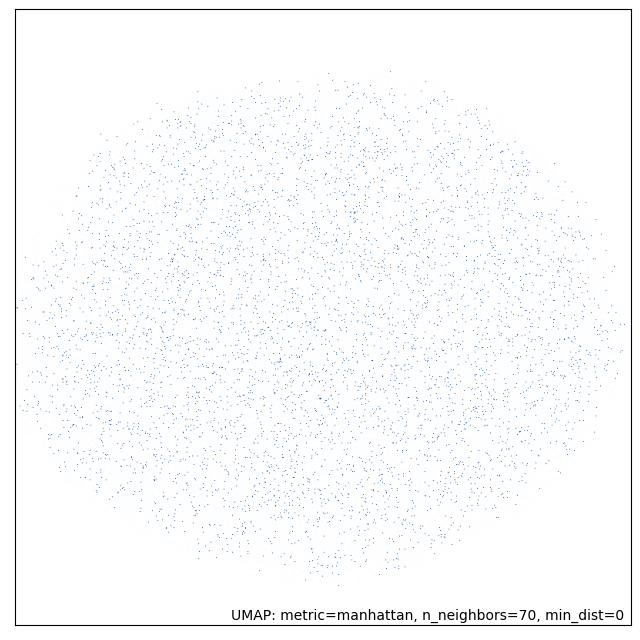

In [8]:
%%time
umap.plot.points(reduced_spikes)